# LSTM Market Predictions: Reconciling Transition Matrices and LSTM

This method constructs a transition matrix from LSTM-based predictions of market direction using historical financial data. First, it downloads stock prices via Alpha Vantage and labels each day as “up” or “down” based on return thresholds to reduce noise. It then builds sequences of past prices, normalized with MinMax scaling, and trains an LSTM to predict the next day's direction. 

To address class imbalance and overfitting, the model uses class weights and a lightweight architecture with one LSTM layer followed by dense layers. After training, predictions are mapped back to the two-day sequences that preceded them, and these mappings are aggregated to form a second-order transition matrix. The resulting matrix provides a probabilistic view of how different recent regimes are expected to evolve, reconciling black-box LSTM outputs with interpretable Markov-style structure.

In [123]:
# === INSTALL REQUIRED PACKAGES ===
# pip install alpha_vantage pandas numpy tensorflow scikit-learn matplotlib seaborn

from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sb


In [124]:
# === STEP 1: LOAD DATA FROM ALPHA VANTAGE ===
api_key = 'WT3P7957XP6T1AU1'  # Replace with your key
symbol = 'TSLA'

ts = TimeSeries(key=api_key, output_format='pandas')
data, _ = ts.get_daily(symbol=symbol, outputsize='full')

In [125]:
# === STEP 2: PROCESS AND LABEL DATA ===
data = data.rename(columns={'4. close': 'Close'})
data = data.sort_index()
data = data.loc['2004-01-01':'2025-05-14'].copy()

# Compute returns
data['return'] = data['Close'].pct_change()

# Apply threshold: classify only significant movements
threshold = 0.002  # ~0.2%
data['state'] = np.where(data['return'] > threshold, 1,
                  np.where(data['return'] < -threshold, 0, np.nan))
data = data.dropna().reset_index(drop=True)

# Normalize prices for LSTM
scaler = MinMaxScaler()
data['Close_scaled'] = scaler.fit_transform(data[['Close']])

In [126]:
# === STEP 3: SEQUENCE CONSTRUCTION ===
def create_sequences(series, states, seq_len=10):
    X, y = [], []
    for i in range(len(series) - seq_len):
        if np.isnan(states[i+seq_len]):
            continue
        X.append(series[i:i+seq_len])
        y.append(states[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(data['Close_scaled'].values, data['state'].values, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [127]:
# === STEP 4: SPLIT + BALANCE ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=False)

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

In [137]:
# === STEP 5: LSTM MODEL ===
model = Sequential([
    LSTM(32, input_shape=(sequence_length, 1)),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Output: down or up
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=70, validation_data=(X_val, y_val), class_weight=class_weights, verbose=1)

Epoch 1/70
82/82 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.5180 - val_loss: 0.6934 - val_accuracy: 0.4856
Epoch 2/70
82/82 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.4631 - val_loss: 0.6933 - val_accuracy: 0.4856
Epoch 3/70
82/82 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4808 - val_loss: 0.6933 - val_accuracy: 0.4856
Epoch 4/70
82/82 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.4697 - val_loss: 0.6932 - val_accuracy: 0.4856
Epoch 5/70
82/82 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.4716 - val_loss: 0.6932 - val_accuracy: 0.4856
Epoch 6/70
82/82 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy: 0.4856
Epoch 7/70
82/82 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4856
Epoch 8/70
82/82 [==

In [138]:
# === STEP 6: PREDICT AND BUILD TRANSITION MATRIX ===
probs = model.predict(X_val)
pred_class = np.argmax(probs, axis=1)

# For each prediction, label the 2-day real sequence preceding it
true_states = y_val
sequence_labels = [f"{true_states[i-2]}-{true_states[i-1]}" for i in range(2, len(true_states))]
pred_trimmed = pred_class[2:]

df_pred = pd.DataFrame({'sequence': sequence_labels, 'predicted_state': pred_trimmed})
counts = df_pred.groupby(['sequence', 'predicted_state']).size().unstack().fillna(0)
transition_matrix = counts.div(counts.sum(axis=1), axis=0)
transition_matrix = transition_matrix.rename(columns={0: 'down', 1: 'up'})

28/28 [==============================] - 0s 527us/step



✅ LSTM-Reconciled 3-Day Transition Matrix:
predicted_state  down
sequence             
0.0-0.0           1.0
0.0-1.0           1.0
1.0-0.0           1.0
1.0-1.0           1.0


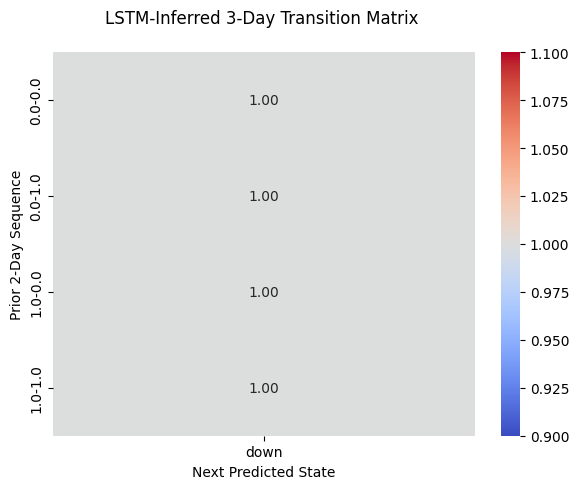

In [139]:
# === STEP 7: DISPLAY AND VISUALIZE ===
print("\n✅ LSTM-Reconciled 3-Day Transition Matrix:")
print(transition_matrix)

# Heatmap visualization
plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("LSTM-Inferred 3-Day Transition Matrix \n")
plt.xlabel("Next Predicted State")
plt.ylabel("Prior 2-Day Sequence")
plt.tight_layout()
plt.show()